# Earthquake Prediction Model with Machine Learning

It is well known that if a disaster occurs in one region, it is likely to happen again. Some regions have frequent earthquakes, but this is only a comparative amount compared to other regions.

So, predicting the earthquake with date and time, latitude and longitude from previous data is not a trend that follows like other things, it happens naturally.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("C:\\Users\\priya\\Downloads\\project\\Earthquake Prediction analysis/Dataset.txt")
data.columns

Index(['Date', 'Time', 'Latitude', 'Longitude', 'Type', 'Depth', 'Depth Error',
       'Depth Seismic Stations', 'Magnitude', 'Magnitude Type',
       'Magnitude Error', 'Magnitude Seismic Stations', 'Azimuthal Gap',
       'Horizontal Distance', 'Horizontal Error', 'Root Mean Square', 'ID',
       'Source', 'Location Source', 'Magnitude Source', 'Status'],
      dtype='object')

In [3]:
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
data.tail()

,Date,Time,Latitude,Longitude,Depth,Magnitude
21951,12/28/2016,08:22:12,38.3917,-118.8941,12.30,5.6
21952,12/28/2016,09:13:47,38.3777,-118.8957,8.80,5.5
21953,12/28/2016,12:38:51,36.9179,140.4262,10.00,5.9
21954,12/29/2016,22:30:19,-9.0283,118.6639,79.00,6.3
21955,12/30/2016,20:08:28,37.3973,141.4103,11.94,5.5


In [4]:
import datetime
import time

timestamp = []
for d, t in zip(data['Date'], data['Time']):
    try:
        ts = datetime.datetime.strptime(d+' '+t, '%m/%d/%Y %H:%M:%S')
        timestamp.append(time.mktime(ts.timetuple()))
    except ValueError:
        print('ValueError')
        timestamp.append('ValueError')
timeStamp = pd.Series(timestamp)
data['Timestamp'] = timeStamp.values
final_data = data.drop(['Date', 'Time'], axis=1)
final_data = final_data[final_data.Timestamp != 'ValueError']
final_data.head()
        




ValueError
ValueError
ValueError


,Latitude,Longitude,Depth,Magnitude,Timestamp
0,-29.400,-177.169,35.0,5.6,42060.0
1,24.185,102.543,11.3,7.1,300641.0
2,23.984,102.732,15.0,5.9,368350.0
3,-9.583,151.493,15.0,6.3,432354.0
4,15.785,-59.808,36.7,6.0,527174.0


In [5]:
!pip install basemap

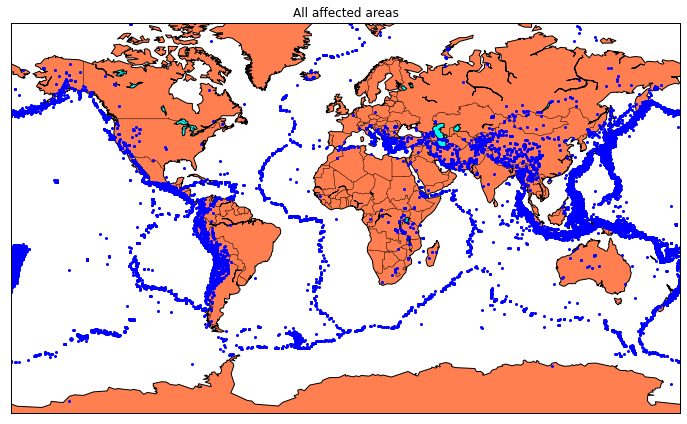

In [6]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()
#m = Basemap(width=12000000,height=9000000,projection='lcc',
            #resolution=None,lat_1=80.,lat_2=55,lat_0=80,lon_0=-107.)
x,y = m(longitudes,latitudes)

fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()

# Splitting the Dataset

Now, to create the earthquake prediction model, we need to divide the data into Xs and ys which respectively will be entered into the model as inputs to receive the output from the model.

Here the inputs are TImestamp, Latitude and Longitude and the outputs are Magnitude and Depth. I’m going to split the xs and ys into train and test with validation. The training set contains 80% and the test set contains 20%:



In [7]:
X = final_data[['Timestamp', 'Latitude', 'Longitude']].values.astype(np.float32)
y = final_data[['Magnitude', 'Depth']].values.astype(np.float32)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, X_test.shape)

(17562, 3) (4391, 3) (17562, 2) (4391, 3)


In [8]:
!pip install keras
!pip install tensorflow

In [9]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import activations 
def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [10]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

# neurons = [16, 64, 128, 256]
neurons = [16]
# batch_size = [10, 20, 50, 100]
batch_size = [10]
epochs = [10]
# activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear', 'exponential']
activation = ['sigmoid', 'relu']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
optimizer = ['SGD', 'Adadelta']
loss = ['squared_hinge']

param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs, activation=activation, optimizer=optimizer, loss=loss)

C:\Users\priya\AppData\Local\Temp/ipykernel_20940/372383517.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


# GRID SEARCH

In [11]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(3,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', loss='squared_hinge', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=10, epochs=20, verbose=1, validation_data=(X_test, y_test))

[test_loss, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))